**Inspecting the details of GPU assigned**

In [3]:
!nvidia-smi

Mon Jul  3 09:39:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Import the required libraries**

In [4]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils



**Load EMNIST training dataset**

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/emnist-balanced-train.csv', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_df.shape

(112800, 785)

**Mount the Google Drive**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Split training dataframe into X & Y**

In [8]:
X_train = train_df.loc[:, 1:]
y_train = train_df.loc[:, 0]

X_train.shape, y_train.shape

((112800, 784), (112800,))

In [9]:
X_train.head()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
y_train.head()

0    45
1    36
2    43
3    15
4     4
Name: 0, dtype: int64

***Create label dictionary***

In [11]:
label_map = pd.read_csv("/content/drive/MyDrive/emnist-balanced-mapping.txt",
                        delimiter = ' ',
                        index_col=0,
                        header=None,
                        squeeze=True)

<ipython-input-11-5cd47ee8e7da>:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  label_map = pd.read_csv("/content/drive/MyDrive/emnist-balanced-mapping.txt",


In [12]:
label_map.head()

0
0    48
1    49
2    50
3    51
4    52
Name: 1, dtype: int64

**After mapping**

In [13]:
label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

**Visualize sample data**

In [14]:
# Sample entry number 43
sample_image = X_train.iloc[43]
sample_label = y_train.iloc[43]
sample_image.shape, sample_label

((784,), 22)

In [15]:
W = 28 ##image width and height size
H = 28

**Horizontal flipping and Rotation**

Label entry 43: M


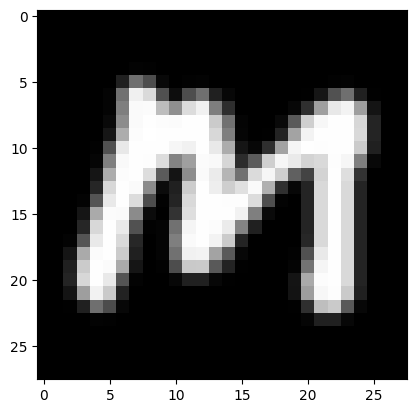

In [16]:
def reshape_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image
print("Label entry 43:", label_dictionary[sample_label])
plt.imshow(reshape_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

In [17]:
# np.apply_along_axis returns a numpy array
X_train = np.apply_along_axis(reshape_and_rotate, 1, X_train.values)
X_train.shape

(112800, 28, 28)

**Visualizing more sample**

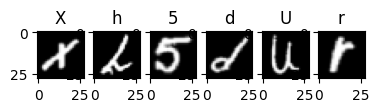

In [18]:
for i in range(100, 106):
    plt.subplot(390 + (i+1))
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_train[i]])

**Normalize Data**

In [19]:
X_train = X_train.astype('float32') / 255 ##converting the img pixels to normalized value

In [20]:
number_of_classes = y_train.nunique()
number_of_classes ##number of unique calsses

47

**Applying One Hot Encoding**

In [21]:
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_train.shape

(112800, 47)

In [22]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

**Reshape to fit model input shape**

In [23]:
# Tensorflow (batch, width, height, channels)
X_train = X_train.reshape(-1, W, H, 1)
X_train.shape

(112800, 28, 28, 1)

**Split 10% validation**

In [24]:
# Split 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size= 0.1,
                                                  random_state=88)

**Model Training**

In [25]:
model = Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(W, H, 1)))

model.add(layers.MaxPool2D(strides=2))

model.add(layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))

model.add(layers.MaxPool2D(strides=2))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(84, activation='relu'))

model.add(layers.Dense(number_of_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 256)               3

In [26]:
optimizer_name = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint('my_model.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

In [27]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping, mcp_save])

Epoch 1/30
2856/2856 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7870
Epoch 1: val_loss improved from inf to 0.41304, saving model to my_model.h5
2856/2856 [==============================] - 27s 5ms/step - loss: 0.6613 - accuracy: 0.7870 - val_loss: 0.4130 - val_accuracy: 0.8517
Epoch 2/30
2850/2856 [============================>.] - ETA: 0s - loss: 0.3805 - accuracy: 0.8641
Epoch 2: val_loss improved from 0.41304 to 0.36501, saving model to my_model.h5
2856/2856 [==============================] - 14s 5ms/step - loss: 0.3805 - accuracy: 0.8641 - val_loss: 0.3650 - val_accuracy: 0.8683
Epoch 3/30
2855/2856 [============================>.] - ETA: 0s - loss: 0.3255 - accuracy: 0.8791
Epoch 3: val_loss improved from 0.36501 to 0.35239, saving model to my_model.h5
2856/2856 [==============================] - 14s 5ms/step - loss: 0.3254 - accuracy: 0.8792 - val_loss: 0.3524 - val_accuracy: 0.8722
Epoch 4/30
2855/2856 [============================>.] - ETA: 0s - lo

**Test model**

Saving the model

In [28]:
# Load best model
model = load_model('my_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 256)               3

In [29]:
y_pred = model.predict(X_val)
y_pred.shape

353/353 [==============================] - 1s 2ms/step


(11280, 47)

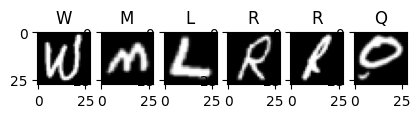

In [30]:
for i in range(10, 16):
    plt.subplot(380 + (i%10+1))
    plt.imshow(X_val[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.title(label_dictionary[y_pred[i].argmax()])

**Test accuracy**

In [31]:
model.evaluate(X_val, y_val)

353/353 [==============================] - 1s 4ms/step - loss: 0.3674 - accuracy: 0.8765


[0.3673800528049469, 0.8765071034431458]

**Load test dataset & preprocess image like how we did to train dataset**

In [32]:
test_df = pd.read_csv('/content/drive/MyDrive/emnist-balanced-test.csv', header=None)
test_df.shape

(18800, 785)

In [33]:
test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,18800.000000,18800.0,18800.0,18800.0,18800.0,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,...,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0
mean,23.000000,0.0,0.0,0.0,0.0,0.006064,0.019734,0.011277,0.009362,0.011277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,13.565021,0.0,0.0,0.0,0.0,0.528828,1.761298,1.054441,0.892318,1.517275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,11.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,23.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,35.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,46.000000,0.0,0.0,0.0,0.0,63.000000,213.000000,108.000000,95.000000,208.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_test = test_df.loc[:, 1:]
y_test = test_df.loc[:, 0]

X_test.shape, y_test.shape

((18800, 784), (18800,))

In [35]:
X_test = np.apply_along_axis(reshape_and_rotate, 1, X_test.values)
y_test = np_utils.to_categorical(y_test, number_of_classes)

X_test.shape, y_test.shape

((18800, 28, 28), (18800, 47))

**Normalize Again**

In [36]:
X_test = X_test.astype('float32') / 255

In [37]:
X_test = X_test.reshape(-1, W, H, 1)
X_test.shape

(18800, 28, 28, 1)

In [38]:
model.evaluate(X_test, y_test)

588/588 [==============================] - 2s 3ms/step - loss: 0.3770 - accuracy: 0.8752


[0.37701117992401123, 0.8752127885818481]

**Saving the model**

In [39]:
model.save('CNN-emnist-model.h5')

**Installing the gradio**

In [40]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
 

**Import libraries**

In [41]:
import gradio as gr
import tensorflow as tf
import cv2


title = "Mnist Digit classifier"

**Declaring variables**

In [42]:
img_size = 28
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L","M", "N", "O", "P", "Q", "S", "T", "U", "V", "X", "Y", "Z", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t"]

**Loading the model**

In [43]:
model = tf.keras.models.load_model("/content/CNN-emnist-model.h5")

In [44]:
def predict(img):

  img = cv2.resize(img, (img_size, img_size))
  img = img.reshape(1, img_size, img_size, 1)

  preds = model.predict(img)[0]

  return {label: float(pred) for label, pred in zip(labels, preds)}

label = gr.outputs.Label(num_top_classes=3)

/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


**Creating interface**

In [ ]:
interface = gr.Interface(fn=predict, inputs="sketchpad", outputs=label, title=title)
interface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 32ms/step
